In [1]:
import torch
from torch import nn, Tensor

In [2]:
def get_1d_rotary_embed(dim:int, pos: Tensor, base:int=10000):
    assert dim % 2 == 0
    thetas = 1.0 / (base ** (torch.arange(0, dim, 2, device=pos.device).float() / dim))
    thetas = pos.unsqueeze(-1) * thetas  # (N, D/2)
    thetas = torch.cat((thetas, thetas), dim=-1)  # (N, D)
    return thetas    

def get_foveated_pos_embed(
    centers: Tensor,
    grid_shape: tuple,
    crop_scale: float,
    feat_shape: tuple,
    dim: int = 384,
    base: int = 10000,
):
    batch_size = centers.shape[0]
    assert centers.shape[-1] == 2, "centers should have shape (B, ..., 2) where last dimension is (x, y) coordinates"

    crop_shape = (crop_scale * grid_shape[0], crop_scale * grid_shape[1])
    patch_shape = (crop_shape[0] / feat_shape[0], crop_shape[1] / feat_shape[1])
    num_axis = len(centers.shape[1:-1]) + 2
    assert dim % num_axis == 0
    axis_dim = dim // num_axis
    assert axis_dim % 2 == 0

    # Create meshgrid along eash axis
    axis_grids = list(torch.meshgrid(
        *[torch.arange(d, dtype=torch.float32, device=centers.device) for d in centers.shape[1:-1]],
        torch.linspace(-crop_shape[0]/2 + patch_shape[0]/2, crop_shape[0]/2 - patch_shape[0]/2, feat_shape[0], device=centers.device),
        torch.linspace(-crop_shape[1]/2 + patch_shape[1]/2, crop_shape[1]/2 - patch_shape[1]/2, feat_shape[1], device=centers.device),
        indexing="ij",
    ))
    for i in range(len(axis_grids) - 2):
        axis_grids[i] = axis_grids[i].unsqueeze(0).expand(batch_size, *axis_grids[i].shape)
    axis_grids[-2] = axis_grids[-2].unsqueeze(0) + centers[...,1].unsqueeze(-1).unsqueeze(-1) * grid_shape[0] / 2
    axis_grids[-1] = axis_grids[-1].unsqueeze(0) + centers[...,0].unsqueeze(-1).unsqueeze(-1) * grid_shape[1] / 2
    # Compute position embeddings for each axis and concatenate
    axis_thetas = [
        get_1d_rotary_embed(axis_dim, axis_grid.flatten(start_dim=1), base)
        for axis_grid in axis_grids
    ]
    thetas = torch.cat(axis_thetas, dim=-1)

    return thetas, axis_grids

torch.Size([64, 1024, 384])


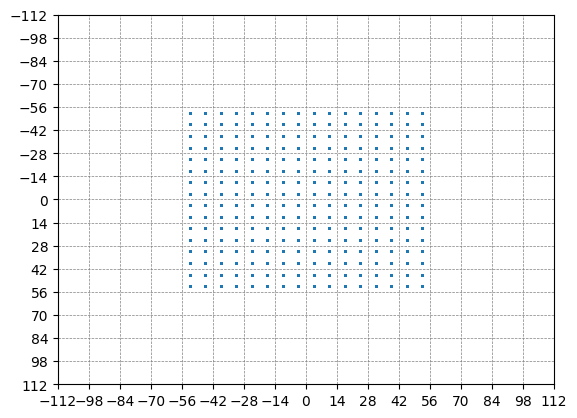

In [ ]:
batch_size = 64
n_images = 2
n_obs_steps = 2
patch_size = 14

centers = torch.zeros((batch_size, n_obs_steps, n_images, 2), dtype=torch.float32)
centers[:,:,:,0] += 0
centers[:,:,:,1] += 0

grid_shape = (240, 320)
crop_scale = 0.5
feat_shape = (5, 5)

thetas, meshgrid = get_foveated_pos_embed(
    centers=centers,
    grid_shape=grid_shape,
    crop_scale=crop_scale,
    feat_shape=feat_shape,
    dim=384,
    base=10000
)

print(thetas.shape)  # Should be (B, S*N, D)

import matplotlib.pyplot as plt
import numpy as np
plt.scatter(meshgrid[-1].cpu().numpy(), meshgrid[-2].cpu().numpy(), s=1)
# draw grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
# draw ticks from -112 to 112 on both axes skip 14
plt.xticks(torch.arange(-112, 113, 14))
plt.yticks(torch.arange(-112, 113, 14))
# make equal aspect ratio
# plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()
plt.show()



In [1]:
from gym_av_aloha.datasets.av_aloha_dataset import AVAlohaDataset
from torch.utils.data import DataLoader
#  create dataset
fps = 8.33333333333333
observation_indices = [0]
observation_timestamps = [i/fps for i in observation_indices]
delta_timestamps = {
    "observation.images.zed_cam_left": observation_timestamps,
    "left_eye": observation_timestamps,
}
dataset = AVAlohaDataset(
    repo_id="iantc104/av_aloha_sim", 
    delta_timestamps=delta_timestamps,
)

In [2]:
dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0,
)

batch = next(iter(dataloader))

In [3]:
batch['task']

['pour ball into test tube',
 'insert stick into slot',
 'hook package',
 'pick red cube',
 'insert peg into socket',
 'hook package',
 'pick red cube',
 'thread needle through wall',
 'pour ball into test tube',
 'insert stick into slot',
 'pour ball into test tube',
 'thread needle through wall',
 'pick red cube',
 'insert peg into socket',
 'insert stick into slot',
 'pick red cube',
 'insert peg into socket',
 'insert peg into socket',
 'insert peg into socket',
 'pour ball into test tube',
 'thread needle through wall',
 'pick red cube',
 'insert peg into socket',
 'thread needle through wall',
 'pick red cube',
 'thread needle through wall',
 'insert peg into socket',
 'pick red cube',
 'insert stick into slot',
 'pour ball into test tube',
 'insert stick into slot',
 'insert stick into slot',
 'insert stick into slot',
 'pour ball into test tube',
 'insert stick into slot',
 'pour ball into test tube',
 'hook package',
 'insert stick into slot',
 'pour ball into test tube',
 'in

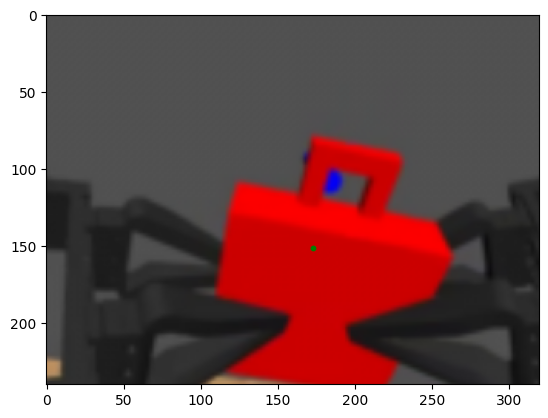

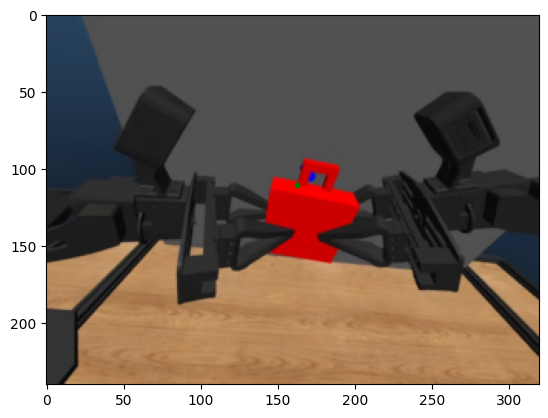

In [151]:
from gaze_av_aloha.policies.foveated_policy.utils import crop_with_keypoints, denormalize_keypoints
from torchvision.ops import roi_align

def denormalize_keypoints(
    keypoints: Tensor, image_size: tuple[int, int]
) -> Tensor:
    """
    Arguments:
        keypoints: Tensor of shape (..., 2)
            where the last dimension contains (x, y) coordinates of keypoints.
        image_size: Tuple (height, width) of the image.
    Denormalize keypoints from [-1, 1] range to pixel coordinates based on image size.
    """
    height, width = image_size
    return torch.stack(
        [
            ((keypoints[..., 0] + 1) / 2) * width,  # Denormalize x to pixel coordinates
            ((keypoints[..., 1] + 1) / 2) * height,  # Denormalize y to pixel coordinates
        ],
        dim=-1,
    )

def normalize_keypoints(
    keypoints: Tensor, image_size: tuple[int, int]
) -> Tensor:
    """
    Arguments:
        keypoints: Tensor of shape (..., 2)
            where the last dimension contains (x, y) coordinates of keypoints.
        image_size: Tuple (height, width) of the image.
    Normalize keypoints to [-1, 1] range based on image size.
    """
    height, width = image_size
    return torch.stack(
        [
            (keypoints[..., 0] / width) * 2 - 1,  # Normalize x to [-1, 1]
            (keypoints[..., 1] / height) * 2 - 1,  # Normalize y to [-1, 1]
        ],
        dim=-1,
    )

def batched_crop(images: torch.Tensor, crop_bounds: torch.Tensor, out_shape: tuple) -> torch.Tensor:
    """
    Crops images based on the provided crop bounds and resizes them to the specified output shape.
    Args:
        images (torch.Tensor): Input images of shape [B, C, H, W].
        crop_bounds (torch.Tensor): Crop bounds of shape [B, 2, 2], where each entry is [[x1, y1], [x2, y2]].
        out_shape (tuple): Desired output shape for the cropped images, e.g., (H_out, W_out).
    Returns:
        torch.Tensor: Cropped and resized images of shape [B, C, H_out, W_out].
    """
    B = crop_bounds.shape[0]
    batch_indices = torch.arange(B, device=crop_bounds.device, dtype=crop_bounds.dtype).unsqueeze(1)

    # Concatenate batch index with crop coordinates
    boxes = torch.cat([
        batch_indices,                      # (B, 1)
        crop_bounds[:, 0, 0:1],            # x1
        crop_bounds[:, 0, 1:2],            # y1
        crop_bounds[:, 1, 0:1],            # x2
        crop_bounds[:, 1, 1:2],            # y2
    ], dim=1)  # (B, 5)

    return roi_align(images, boxes, output_size=out_shape, aligned=True)

def get_crop_bounds(center: torch.Tensor, crop_shape: torch.Tensor) -> torch.Tensor:
    """
    Arguments:
        center: Tensor of shape (..., 2) where the last dimension contains (x, y) coordinates of the center of the crop.
        crop_size: Tensor of shape (2,)
            Size of the crop in the format (height, width).
    Returns:
        Tensor of shape (..., 2, 2) where the last dimension contains the lower and upper corners of the crop.
        The shape of the output is determined by the shape of the `center` tensor.
        The output will be in the format [[[x1, y1], [x2, y2]]], where (x1, y1) is the lower corner
        and (x2, y2) is the upper corner of the crop.
    """
    crop_size = torch.tensor(crop_shape[::-1], device=center.device, dtype=center.dtype)
    lower_corner = (center - crop_size / 2)
    upper_corner = lower_corner + crop_size
    return torch.stack([lower_corner, upper_corner], dim=1)  

def crop_at_kp(images: Tensor, crop_scale: float, kp: Tensor, out_shape: tuple = None) -> Tensor:
    image_shape = images.shape[-2:]
    crop_shape = (crop_scale * image_shape[0], crop_scale * image_shape[1])
    center = denormalize_keypoints(kp, image_size=image_shape)
    if out_shape is None:
        out_shape = crop_shape
    crop_bounds = get_crop_bounds(
        center=center,
        crop_shape=crop_shape,
    ) 
    return batched_crop(
        images=images,
        crop_bounds=crop_bounds,
        out_shape=out_shape,
    )

def random_crop(images: Tensor, crop_scale: float, kp: Tensor = None, out_shape: tuple = None, random: bool = True) -> tuple[Tensor, Tensor]:
    """
    Args:
        images (Tensor): Input images of shape [B, C, H, W].
        crop_scale (float): Scale factor for the crop size relative to the image size.
        out_shape (tuple, optional): Desired output shape for the cropped images, e.g., (H_out, W_out).
        random (bool): If True, crops randomly within the image dimensions.
    """
    # create random crop bounds within the image dimensions
    B = images.shape[0]
    image_shape = images.shape[-2:]
    crop_shape = (crop_scale * image_shape[0], crop_scale * image_shape[1])

    if random:
        center = torch.stack([
            torch.rand(B, device=images.device, dtype=images.dtype) * (image_shape[1] - crop_shape[1]) + crop_shape[1] / 2,
            torch.rand(B, device=images.device, dtype=images.dtype) * (image_shape[0] - crop_shape[0]) + crop_shape[0] / 2,
        ], dim=1)
    else:
        center = torch.stack([
            torch.ones(B, device=images.device, dtype=images.dtype) * image_shape[1] / 2,
            torch.ones(B, device=images.device, dtype=images.dtype) * image_shape[0] / 2,
        ], dim=1)
    # plt.scatter(center[:, 0].cpu().numpy(), center[:, 1].cpu().numpy(), s=1)
    # plt.xlim(0, image_shape[1])
    # plt.ylim(0, image_shape[0])
    # plt.show()
    crop_bounds = get_crop_bounds(
        center=center,
        crop_shape=crop_shape,
    )
    crop = batched_crop(
        images=images,
        crop_bounds=crop_bounds,
        out_shape=out_shape,
    )

    # modify kp to new crop bounds
    if kp is not None:
        kp = denormalize_keypoints(kp, image_size=image_shape) if kp is not None else None
        kp = torch.stack([
            kp[..., 0] - crop_bounds[:, 0, 0],
            kp[..., 1] - crop_bounds[:, 0, 1],
        ], dim=-1)
        kp = normalize_keypoints(kp, image_size=crop_shape)

    return crop, kp


img = batch["observation.images.zed_cam_left"][:, 0]
gaze = batch["left_eye"][:, 0]
crop = crop_at_kp(
    images=img, 
    kp=gaze,
    crop_scale=0.4,
    out_shape=(240, 320),
)
# crop, crop_gaze = random_crop(
#     images=img, 
#     crop_scale=0.9,
#     out_shape=(224, 294),
#     kp=gaze,
#     random=True,
# )

import matplotlib.pyplot as plt
kp = denormalize_keypoints(crop_gaze, image_size=crop.shape[-2:])[0].cpu().numpy()
viz = (crop[0] * 255).cpu().numpy().transpose(1, 2, 0).astype('uint8')
plt.imshow(viz)
plt.scatter(kp[0], kp[1], s=10, c='green')
plt.show()

import matplotlib.pyplot as plt
kp = denormalize_keypoints(gaze, image_size=img.shape[-2:])[0].cpu().numpy()
viz = (img[0] * 255).cpu().numpy().transpose(1, 2, 0).astype('uint8')
plt.imshow(viz)
plt.scatter(kp[0], kp[1], s=10, c='green')
plt.show()
